##### 2.4. Predicting Price with Size, Location, and Neighborhood

In [1]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns   # Data visualization
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact   # Interactive dashboard
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In the final lesson for this project, we're going to try to use all the features in our dataset to improve our model. This means that we'll have to do a more careful cleaning of the dataset and consider some of the finer points of linear models.

Prepare Data

Import

In [32]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath, encoding = "latin1")

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop features / columns with high null counts
    df.drop(columns = ["floor", "expenses"], inplace = True)

    # Drop low- and high-cardinality categorical variables
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace = True)

    # Drop leaky columns
    df.drop(
        columns = [
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2'
        ], 
        inplace = True
    )

    # Drop columns with multicollinearlity
    df.drop(columns = ["surface_total_in_m2", "rooms"], inplace = True)
    
    return df

Let's begin by using what we've learned to load all our CSV files into a DataFrame.

Task 2.4.1: Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory. Assign this list to the variable name files. 

In [33]:
files = glob("datasets/buenos-aires-real-estate-*.csv")
files

['datasets\\buenos-aires-real-estate-1.csv',
 'datasets\\buenos-aires-real-estate-2.csv',
 'datasets\\buenos-aires-real-estate-3.csv',
 'datasets\\buenos-aires-real-estate-4.csv',
 'datasets\\buenos-aires-real-estate-5.csv']

In [6]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

The last time we put all our DataFrames into a list, we used a for loop. This time, we're going to use a more compact coding technique called a list comprehension.

Task 2.4.2: Use your wrangle function in a list comprehension to create a list named frames. The list should contain the cleaned DataFrames for the filenames your collected in files.

In [34]:
''' 
If you use for loop
frames = []

for file in files:
    df = wrangle(file)
    frames.append(df)
'''
# list comprehension
frames = [wrangle(file) for file in files]

In [10]:
print(type(frames))
print(len(frames))
print(type(frames[0]))
frames[0].head()

<class 'list'>
5
<class 'pandas.core.frame.DataFrame'>


,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
4,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
9,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
29,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
40,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
41,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [8]:
# Check your work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

Last step: Combine the DataFrames in frames into a single df.

Task 2.4.3: Use pd.concat to concatenate it items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True.

In [35]:
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [11]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

Explore

The first thing we need to consider when trying to use all the features df is missing values. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from df.info() above. Are there columns where more than half of the values are NaN? If so, those columns need to go!

Task 2.4.4: Modify your wrangle function to drop any columns that are more than half NaN values. Be sure to rerun all the cells above before you continue.

In [13]:
df.isnull().sum()

operation                        0
property_type                    0
price                            0
currency                         0
price_aprox_local_currency       0
price_aprox_usd                  0
surface_total_in_m2           1830
surface_covered_in_m2            0
price_usd_per_m2              2046
price_per_m2                     0
floor                         4682
rooms                         1296
expenses                      4843
properati_url                    0
lat                            266
lon                            266
neighborhood                     0
dtype: int64

In [15]:
df.isnull().sum() / len (df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
floor                         0.711334
rooms                         0.196901
expenses                      0.735795
properati_url                 0.000000
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

In [12]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

The next thing we need to look out for are categorical columns with low or high cardinality. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.


Task 2.4.5: Calculate the number of unique values for each non-numeric feature in df.

In [13]:
df.select_dtypes("object").head()

,operation,property_type,currency,properati_url,neighborhood
0,sell,apartment,USD,http://chacarita.properati.com.ar/10qlv_venta_...,Chacarita
1,sell,apartment,USD,http://villa-luro.properati.com.ar/12m82_venta...,Villa Luro
2,sell,apartment,USD,http://caballito.properati.com.ar/11wqh_venta_...,Caballito
3,sell,apartment,USD,http://constitucion.properati.com.ar/k2f0_vent...,Constitución
4,sell,apartment,USD,http://once.properati.com.ar/suwa_venta_depart...,Once


In [14]:
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

Here, we can see that columns like "operation" have only one value in them, while every row in "properati_url" has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

Task 2.4.6: Modify your wrangle function to drop high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

In [19]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 11, f"`df` has too many columns: {df.shape[1]}"

It's also important for us to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

Task 2.4.7: Modify your wrangle function to drop any features that would constitute leakage.

Be sure to rerun all the cells above before you continue.

In [21]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [27]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

Finally, the last issue we need to keep an eye out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

Task 2.4.8: Plot a correlation heatmap of the remaining numerical features in df. Since "price_aprox_usd" will be your target, you don't need to include it in your heatmap.

In [28]:
df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
surface_total_in_m2,1.000000,0.735685,0.596368,0.070392,0.019021
surface_covered_in_m2,0.735685,1.000000,0.784979,0.028538,0.034515
rooms,0.596368,0.784979,1.000000,-0.048557,0.030434
lat,0.070392,0.028538,-0.048557,1.000000,-0.262439
lon,0.019021,0.034515,0.030434,-0.262439,1.000000


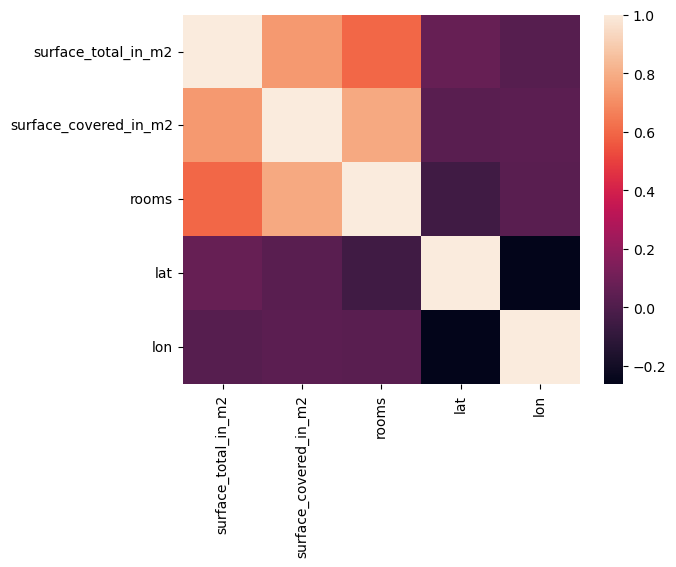

In [30]:
corr = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
sns.heatmap(corr);

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


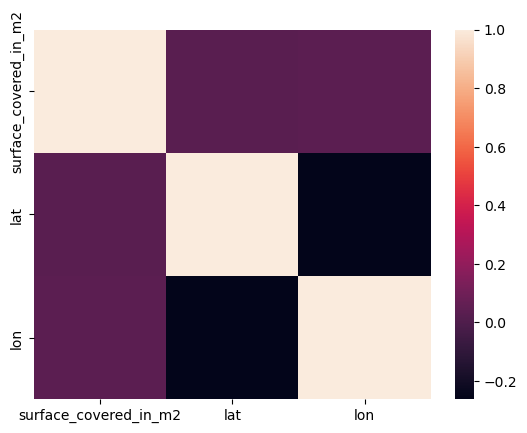

In [37]:
# After dropping the "surface_total_in_m2" & "rooms"
corr2 = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
sns.heatmap(corr2);

Task 2.4.9: Modify your wrangle function to remove columns so that there are no strongly correlated features in your feature matrix.

Be sure to rerun all the cells above before you continue.

In [38]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] == 5, f"`df` has the wrong number of columns: {df.shape[1]}"
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


Done! It looks like we're going to use the four features we've used in our previous models but, this time, we're going to combine them.

Split Data

Task 2.4.10: Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above.

In [41]:
# Split data into feature matrix X_train and target vector y_train
target = "price_aprox_usd"
X_train = df.drop(columns=target)
y_train = df[target]

In [42]:
# Check your work
assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

Build Model

Baseline

Task 2.4.11: Calculate the baseline mean absolute error for your model.

In [43]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


Iterate

Task 2.4.12: Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

In [44]:
# Create the pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy="mean"),
    Ridge()
)
# Fit the model to the training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [45]:
# Check your work
check_is_fitted(model[-1])

Evaluate

Task 2.4.13: Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.

In [46]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330265


Task 2.4.14: Run the code below to import your test data buenos-aires-test-features.csv into a DataFrame and generate a list of predictions using your model. Then run the following cell to submit your predictions to the grader.

In [47]:
X_test = pd.read_csv("datasets/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

Communicate Results

For this lesson, we've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to deploy a model — in other words, use it in action. So let's look at two ways you might deploy this model.

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output.

Task 2.4.15: Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [50]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

Let's see if your function works. Run the cell below to find out!

In [51]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using Jupyter Widgets.

Task 2.4.16: Add your make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.

Create an interact function in Jupyter Widgets.

In [52]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

Great work! You may have noticed that there a lots of ways to improve this dashboard. For instance, a user can select a neighborhood and then supply latitude-longitude coordinates that aren't in that neighborhood. It would also be helpful to include a visualization like a map. Regardless, this is a great first step towards creating dynamic dashboards that turn your model from a complicated abstraction to a concrete tool that anyone can access. One of the most important parts of data science projects is creating products that people can use to make their work or lives easier.